In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
# Load the dataset
data = np.load("complete_cwt_dataset.npz")
X_train, X_test, y_train, y_test = (
    data["X_train"],
    data["X_test"],
    data["y_train"],
    data["y_test"],
)

Random samples from the training set:


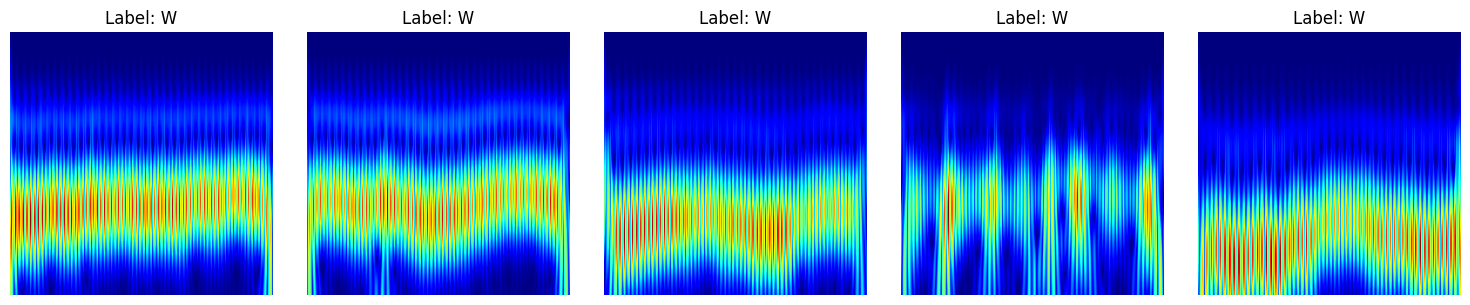

Random samples from the testing set:


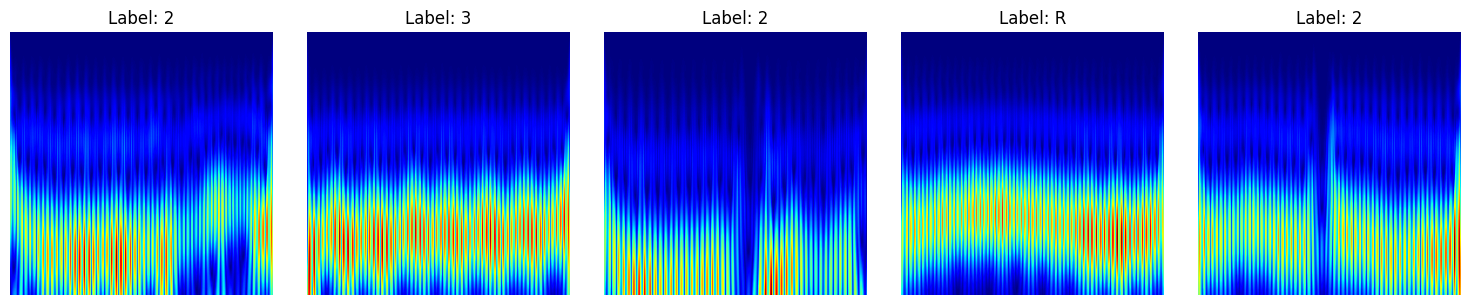

In [3]:
# Define a function to visualize random samples
def visualize_samples(images, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        idx = np.random.randint(len(images))
        axes[i].imshow(
            images[idx], cmap="jet"
        )  # Assuming 'jet' colormap for visualization
        axes[i].set_title(f"Label: {labels[idx]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Visualize random samples from the training set
print("Random samples from the training set:")
visualize_samples(X_train, y_train)

# Visualize random samples from the testing set
print("Random samples from the testing set:")
visualize_samples(X_test, y_test)

Random samples from the modified training set:


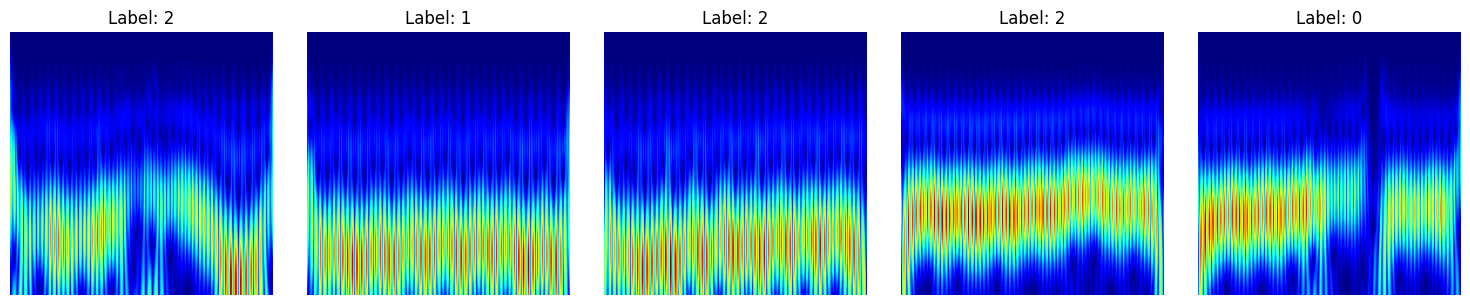

Random samples from the modified testing set:


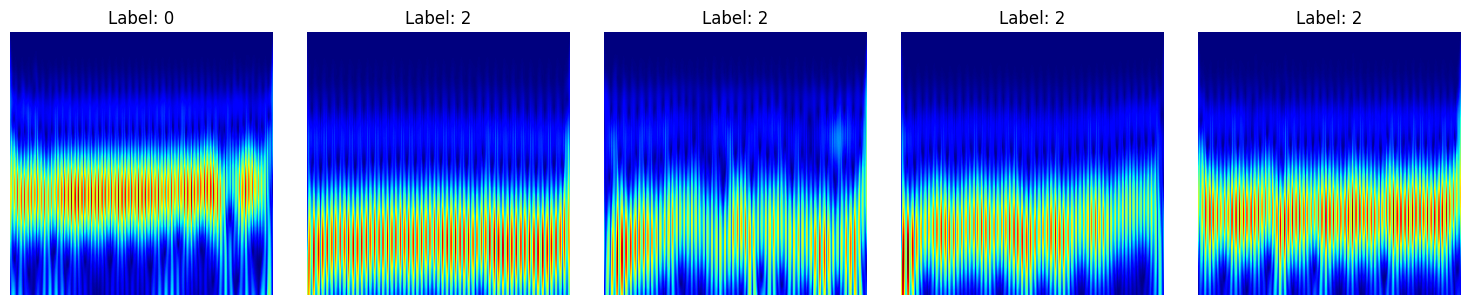

In [4]:
# Define the class mapping
class_mapping = {"W": 0, "R": 1, "1": 2, "2": 2, "3": 2, "4": 2}


# Define a function to apply the mapping to labels
def apply_class_mapping(labels, class_mapping):
    mapped_labels = []
    for label in labels:
        mapped_label = class_mapping.get(
            label, -1
        )  # If label not found in mapping, assign -1
        mapped_labels.append(mapped_label)
    return np.array(mapped_labels)


# Apply the mapping to training and testing labels
y_train_mapped = apply_class_mapping(y_train, class_mapping)
y_test_mapped = apply_class_mapping(y_test, class_mapping)

# Visualize random samples from the modified training set
print("Random samples from the modified training set:")
visualize_samples(X_train, y_train_mapped)

# Visualize random samples from the modified testing set
print("Random samples from the modified testing set:")
visualize_samples(X_test, y_test_mapped)

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Convert to PyTorch tensors and add a channel dimension
X_train = torch.from_numpy(X_train).unsqueeze(1).float().to(device)
X_test = torch.from_numpy(X_test).unsqueeze(1).float().to(device)
y_train = torch.from_numpy(y_train_mapped).float().to(device)
y_test = torch.from_numpy(y_test_mapped).float().to(device)

In [7]:
# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [9]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(256 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 6)  # 6 output classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 256 * 12 * 12)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Instantiate the model and move to GPU
model = CNN().to(device)

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
best_loss = float("inf")
best_model_state = None

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct_val / total_val
    print(
        f"Epoch {epoch + 1}/{num_epochs}- Training Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.2f}%, Validation Loss: {val_loss:.3f}, Accuracy: {val_accuracy:.2f}%"
    )

    # Save best model state
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_state = model.state_dict()

print("Finished Training")

# Save the best model
torch.save(best_model_state, "best_model_allSubjects_dummyCNN.pth")

Epoch 1/50- Training Loss: 0.865, Accuracy: 58.86%, Validation Loss: 0.798, Accuracy: 60.92%
Epoch 2/50- Training Loss: 0.816, Accuracy: 60.41%, Validation Loss: 0.758, Accuracy: 65.54%
Epoch 3/50- Training Loss: 0.779, Accuracy: 62.44%, Validation Loss: 0.762, Accuracy: 64.90%
Epoch 4/50- Training Loss: 0.739, Accuracy: 65.23%, Validation Loss: 0.720, Accuracy: 69.99%
Epoch 5/50- Training Loss: 0.694, Accuracy: 69.41%, Validation Loss: 0.664, Accuracy: 71.37%
